In [47]:
import numpy as np
from tensorflow.keras.datasets import cifar10

# Cargar el conjunto de datos CIFAR-10
(x_train, y_train), (_, _) = cifar10.load_data()

# Seleccionar las primeras 100 imágenes del conjunto de entrenamiento
num_images = 1000
x_subset = x_train[:num_images]
y_subset = y_train[:num_images]

# Verificar las dimensiones del subconjunto
print("Dimensiones del subconjunto de imágenes:", x_subset.shape)  # Debería ser (100, 32, 32, 3) para CIFAR-10

# Ahora x_subset contiene las primeras 100 imágenes y y_subset contiene las etiquetas correspondientes
# Puedes usar x_subset e y_subset en tu código para trabajar con estas imágenes.


Dimensiones del subconjunto de imágenes: (1000, 32, 32, 3)


In [48]:
np.unique(y_subset, return_counts=1)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([102, 112,  99,  92,  99,  85, 107, 102,  99, 103], dtype=int64))

In [99]:
import cv2
import matplotlib.pyplot as plt

# Función para convertir imágenes a escala de grises y aplicar SIFT
def convert_to_gray_and_apply_sift(images):
    gray_images = []
    keypoints_list = []
    descriptors_list = []
    sift = cv2.SIFT_create()
    indice_imagen = []
    for idx, img in enumerate(images):
        # Convertir la imagen a escala de grises
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # gray_img = cv2.resize()
        gray_images.append(gray_img)

        # Aplicar SIFT en la imagen en escala de grises
        keypoints, descriptors = sift.detectAndCompute(gray_img, None)
        
        if not(descriptors is None) and len(descriptors) > 3:
            keypoints_list.append(keypoints)
            descriptors_list.append(descriptors)
            indice_imagen += [idx] * descriptors.shape[0]
        else:
            pass
            # print(img.shape)
            # plt.imshow(img)
        

    return gray_images, keypoints_list, descriptors_list, indice_imagen

# Convertir las imágenes a escala de grises y aplicar SIFT en el subconjunto de imágenes
_, _, descriptors_list, index = convert_to_gray_and_apply_sift(x_subset)

print("Dimensiones del descriptor de la primera imagen:", descriptors_list[1].shape)


Dimensiones del descriptor de la primera imagen: []


In [50]:
l = [v.shape[0] for v in descriptors_list]
print(np.unique(l, return_counts=1))
np.average(l)

(array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 34]), array([27, 28, 33, 41, 53, 42, 66, 73, 63, 97, 82, 66, 55, 58, 46, 41, 30,
       14, 15, 13, 16,  7,  2,  4,  2,  1], dtype=int64))


13.29025641025641

In [51]:
lista_desciptores_aplanado = np.concatenate(descriptors_list) # index

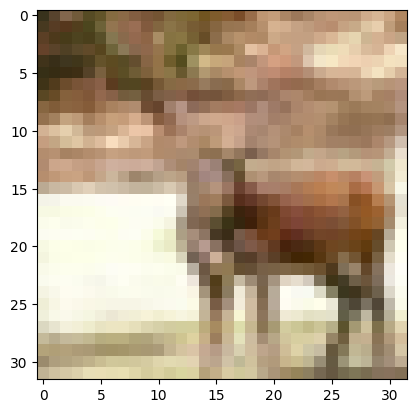

In [54]:
img_busqueda = x_train[1001]
plt.imshow(img_busqueda)

_,_,descriptor_busqueda,_ = convert_to_gray_and_apply_sift([img_busqueda])



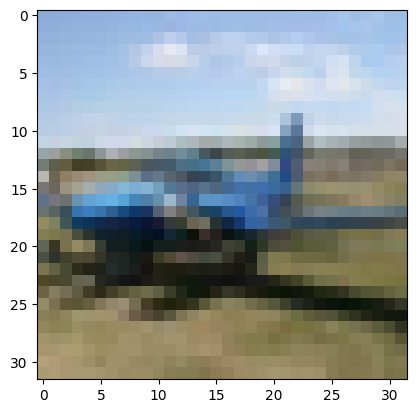

In [96]:
plt.imshow(x_subset[453])

In [58]:
descriptor_busqueda[0].shape

(14, 128)

In [93]:
from sklearn.neighbors import NearestNeighbors
from collections import Counter

# Crear un modelo de k-NN
knn_model = NearestNeighbors(n_neighbors=30)  # Buscar los 5 vecinos más cercanos
knn_model.fit(lista_desciptores_aplanado)  # Ajustar el modelo a los descriptores

# Función para encontrar los vecinos más cercanos para un descriptor dado
def find_nearest_neighbors(descriptor, k = 10):
    descriptor_flat = descriptor.flatten()
    # Encontrar los índices y distancias de los vecinos más cercanos
    distances, indices = knn_model.kneighbors([descriptor_flat], k)  # Obtener k vecinos más cercanos
    return distances, indices

# Ejemplo: Encontrar vecinos más cercanos para el primer descriptor en la primera imagen
contador = Counter()
lista = []
print(len(descriptor_busqueda[0]))
for descriptor in descriptor_busqueda[0]:
    distances, indices = find_nearest_neighbors(descriptor, 20)
    lista.extend([index[indice] for indice in indices[0]])

print(len(lista))
Counter(lista).most_common(10)
# Imprimir los índices de los vecinos más cercanos y sus distancias
#print("Índices de los vecinos más cercanos:", indices)
#print("Distancias a los vecinos más cercanos:", distances)


14
280


[(263, 5),
 (762, 4),
 (381, 4),
 (207, 3),
 (166, 3),
 (81, 3),
 (956, 3),
 (508, 3),
 (779, 3),
 (453, 2)]

# 128 x 128

In [51]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# Ruta del archivo CSV
archivo_csv = './archive/128x128/train.csv'

# Leer el archivo CSV usando un DataFrame de pandas
df = pd.read_csv(archivo_csv)

m_por_n = 2400  # Cambia este valor a cualquier número positivo para reducir, o -1 para no reducir
# 2402 es la logitud de la lista minima que es toys (y quero unsar el -1)

# Crear un diccionario con la estructura deseada y reducir las listas si m_por_n no es -1
diccionario_reducido = {}
for categoria, imagenes in df.groupby('label')['image_name']:
    if m_por_n == -1:
        diccionario_reducido[categoria] = imagenes.tolist()
    else:
        num_imagenes = len(imagenes)
        m = min(m_por_n, num_imagenes)  # Conservar mínimo entre m_por_n y el número de imágenes en la categoría
        diccionario_reducido[categoria] = imagenes[:m].tolist()

In [95]:

# Función para aplicar SIFT a una imagen y obtener los descriptores
def apply_sift_to_image(categoria, nombre):
    ruta_imagen = f'./archive/128x128/{categoria}/{nombre}'
    # imagen = mpimg.imread(ruta_imagen)
    imagen = cv2.imread(ruta_imagen)
    
    # Pasamos a gris
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Inicializar el detector SIFT
    sift = cv2.SIFT_create()
    
    # Encontrar los keypoints y descriptores SIFT en la imagen
    keypoints, descriptors = sift.detectAndCompute(imagen_gris, None)
    try:
        lista_rutas_imagen = [ruta_imagen] * descriptors.shape[0]
    except:
        lista_rutas_imagen = []
        descriptors = [[]]
    
    return lista_rutas_imagen, keypoints, descriptors, imagen_gris

In [40]:
lista = []
lista.append([1,2])
print(lista)

[[1, 2]]


In [50]:
lista_ruta = []
lista_descriptores = []

for key in diccionario_reducido.keys():
    for imagen in diccionario_reducido[key]:
        lista_rutas_imagen, _, descriptors, _ = apply_sift_to_image(key, imagen)
        lista_ruta += lista_rutas_imagen
        lista_descriptores.append(descriptors)


# Eliminar los elementos None de la lista
lista_de_elementos_filtrada = [elemento for elemento in lista_descriptores if elemento is not None]

# Concatenar los elementos en una lista resultante
if lista_de_elementos_filtrada:
    lista_resultante = np.concatenate(lista_de_elementos_filtrada, axis=0)
    print("Forma de la lista resultante:", lista_resultante.shape)  # Debería ser (m, 128)
else:
    print("No hay elementos válidos para concatenar.")

Procesando categorías:   0%|          | 0/11 [00:00<?, ?it/s]

Procesando categorías: 100%|██████████| 11/11 [06:21<00:00, 34.67s/it]


NameError: name 'np' is not defined

In [68]:
diccionario_reducido.keys()

dict_keys(['apparel', 'artwork', 'cars', 'dishes', 'furniture', 'illustrations', 'landmark', 'meme', 'packaged', 'storefronts', 'toys'])

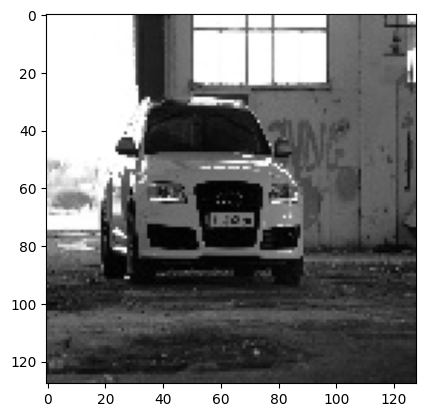

In [102]:
# 2411
categoria = "cars"
nombre = "image2411.jpg"

# plt.imshow(imagen)

_,_,descriptor_busqueda, imagen = apply_sift_to_image(categoria, nombre)
plt.imshow(imagen, cmap='gray')

In [103]:
from sklearn.neighbors import NearestNeighbors
from collections import Counter

# Crear un modelo de k-NN
knn_model = NearestNeighbors(n_neighbors=5)  # Buscar los 5 vecinos más cercanos
knn_model.fit(lista_resultante)  # Ajustar el modelo a los descriptores

# Función para encontrar los vecinos más cercanos para un descriptor dado
def find_nearest_neighbors(descriptor, k = 10):
    descriptor_flat = descriptor.flatten()
    # Encontrar los índices y distancias de los vecinos más cercanos
    distances, indices = knn_model.kneighbors([descriptor_flat], k)  # Obtener k vecinos más cercanos
    return distances, indices

# Ejemplo: Encontrar vecinos más cercanos para el primer descriptor en la primera imagen
contador = Counter()
lista = []
# print(len(descriptor_busqueda))
for descriptor in descriptor_busqueda:
    distances, indices = find_nearest_neighbors(descriptor, 10)
    lista.extend([lista_ruta[indice] for indice in indices[0]])
print(len(lista))
Counter(lista).most_common(10)
# Imprimir los índices de los vecinos más cercanos y sus distancias
#print("Índices de los vecinos más cercanos:", indices)
#print("Distancias a los vecinos más cercanos:", distances)

1360


[('./archive/128x128/meme/image0472.jpeg', 3),
 ('./archive/128x128/storefronts/image1440.jpeg', 3),
 ('./archive/128x128/artwork/image1231.jpeg', 3),
 ('./archive/128x128/cars/image1173.jpg', 3),
 ('./archive/128x128/packaged/image0025.jpg', 3),
 ('./archive/128x128/storefronts/image1702.jpeg', 2),
 ('./archive/128x128/dishes/image0830.jpeg', 2),
 ('./archive/128x128/landmark/image10407.jpg', 2),
 ('./archive/128x128/landmark/image0359.jpg', 2),
 ('./archive/128x128/artwork/image1539.jpeg', 2)]

In [104]:
from sklearn.neighbors import NearestNeighbors
from collections import Counter

# Crear un modelo de k-NN
knn_model = NearestNeighbors(n_neighbors=5)  # Buscar los 5 vecinos más cercanos
knn_model.fit(lista_resultante)  # Ajustar el modelo a los descriptores

# Función para encontrar los vecinos más cercanos para un descriptor dado
def find_nearest_neighbors(descriptor, k = 10):
    descriptor_flat = descriptor.flatten()
    # Encontrar los índices y distancias de los vecinos más cercanos
    distances, indices = knn_model.kneighbors([descriptor_flat], k)  # Obtener k vecinos más cercanos
    return distances, indices

mas_cercano = ""
distancia_minima = np.Inf
for descriptor in descriptor_busqueda:
    distances, indices = find_nearest_neighbors(descriptor, 1)
    # print(distances, indices)
    if distances[0][0] < distancia_minima:
        distancia_minima = distances[0]
        mas_cercano = lista_ruta[indices[0][0]]
print(mas_cercano)

./archive/128x128/illustrations/image1500.png


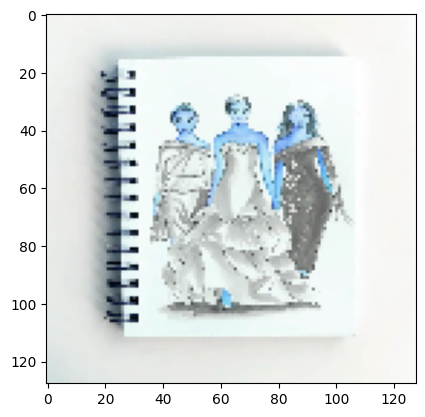

In [105]:
imagen = cv2.imread(mas_cercano)
plt.imshow(imagen)